In [1]:
from dotenv import load_dotenv
import os
import torch
from typing import Optional
from transformers import AutoModelForCausalLM, AutoTokenizer
from localise_units import ImportLLMfromHF, LayersUnits, LocImportantUnits
from dataset import ToMLocDataset
from benchmark import BenchmarkToMi, BenchmarkOpenToM
from assess import AssessBenchmark
load_dotenv()
hf_access_token = os.getenv("HF_ACCESS_TOKEN")
cache_dir = os.getenv("CACHE_DIR")
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Load the model and tokenizer onto GPU
checkpoint = "meta-llama/Llama-3.1-8B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(checkpoint, cache_dir=cache_dir, token=hf_access_token)
model = AutoModelForCausalLM.from_pretrained(checkpoint, cache_dir=cache_dir, token=hf_access_token).to(device)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

(131072,)


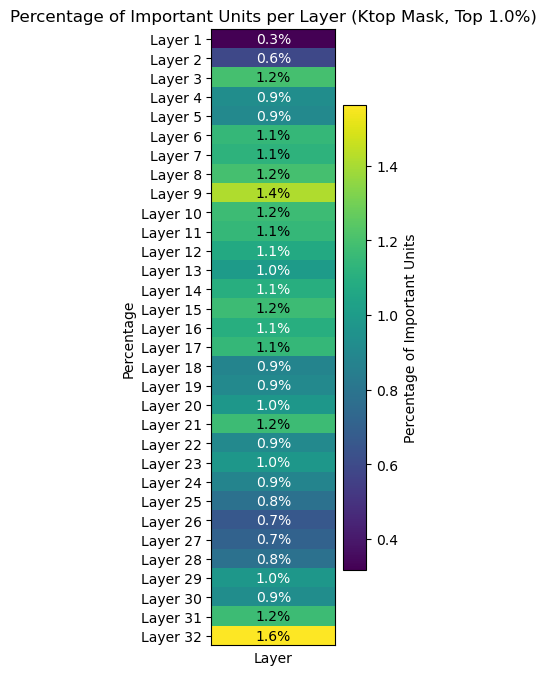

In [2]:
tom_data = ToMLocDataset()
llm = ImportLLMfromHF(model, tokenizer)
units = LayersUnits(llm, tom_data)
loc_units = LocImportantUnits(checkpoint, units.data_activation)
loc_units.plot_layer_percentages(0.01)

In [3]:
from benchmark import BenchmarkOpenToM
bn_tomi = BenchmarkOpenToM(subset=20)
bn_assess = AssessBenchmark(llm, loc_units, batch_size=20)
res = bn_assess.experiment(bn_tomi)

100%|██████████| 3/3 [00:09<00:00,  3.02s/it]


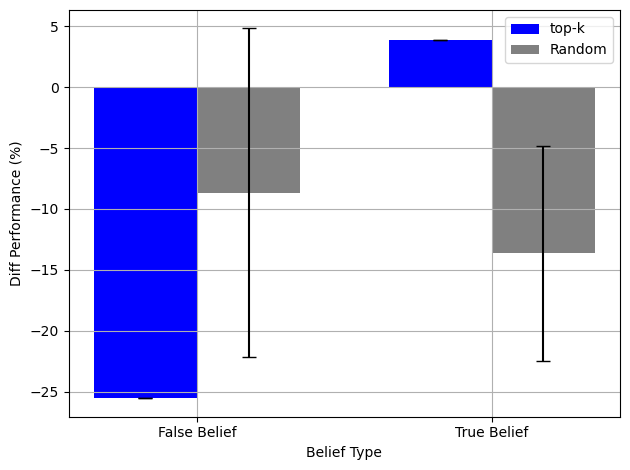

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import json
from scipy.stats import sem, t

def compute_diff(df):
    """
    Computes the difference in performance between ablation and no ablation
    for False Belief and True Belief categories.

    Args:
        df (pd.DataFrame): Data frame containing the necessary columns.

    Returns:
        dict: Dictionary containing differences for "False Belief" and "True Belief."
    """
    falsebelief_df = df[df["falseTrueBelief"] == False]
    truebelief_df = df[df["falseTrueBelief"] == True]

    # Compute differences for top_k
    diff_false_top = (falsebelief_df["answer"] == falsebelief_df["predict_ablate_top_1"]).mean() - (
            falsebelief_df["answer"] == falsebelief_df["predict_no_ablation"]).mean()
    diff_true_top = (truebelief_df["answer"] == truebelief_df["predict_ablate_top_1"]).mean() - (
            truebelief_df["answer"] == truebelief_df["predict_no_ablation"]).mean()

    # Initialize result
    diff = {
        "False Belief": {"top_k": [diff_false_top]},
        "True Belief": {"top_k": [diff_true_top]}
    }

    random_cols = [col for col in df.columns if col.startswith("predict_ablate_random")]
    if random_cols:
        diff["False Belief"]["random"] = []
        diff["True Belief"]["random"] = []
        for random_col in random_cols:
            fbelief_rand = (falsebelief_df["answer"] == falsebelief_df[random_col]).mean() - (falsebelief_df["answer"] == falsebelief_df["predict_no_ablation"]).mean()
            tbelief_rand = (truebelief_df["answer"] == truebelief_df[random_col]).mean() - (truebelief_df["answer"] == truebelief_df["predict_no_ablation"]).mean()
            diff["False Belief"]["random"].append(fbelief_rand)
            diff["True Belief"]["random"].append(tbelief_rand)
    return diff

def compute_mean_and_std(values):
    """
    Computes the mean and standard deviation for a list of values.

    Args:
        values (list): List of numerical values.

    Returns:
        tuple: Mean and standard deviation.
    """
    mean = np.mean(values)
    std = np.std(values)
    return mean, std


def barplot_diff(input_data, input_type="dataframe"):
    """
    Plots a bar plot comparing False Belief and True Belief differences,
    with optional standard deviation error bars.

    Args:
        input_data: Either a pandas DataFrame or a JSON file path containing the data.
        input_type (str): Type of input, either "dataframe" or "json".

    Returns:
        None
    """
    # Determine the source of data
    if input_type == "dataframe":
        # Compute differences from the DataFrame
        diff = compute_diff(input_data)
    elif input_type == "json":
        # Load differences from the JSON file
        with open(input_data, "r") as json_file:
            diff = json.load(json_file)
    else:
        raise ValueError("Invalid input_type. Must be 'dataframe' or 'json'.")

    # Extracting data for plotting
    categories = ["False Belief", "True Belief"]
    means_topk = []
    stds_topk = []
    means_random = []
    stds_random = []

    has_random = False  # Check if random values exist
    for category in categories:
        # Compute mean and std for "top_k"
        mean_topk, std_topk = compute_mean_and_std(diff[category]["top_k"])
        means_topk.append(mean_topk * 100)
        stds_topk.append(std_topk * 100)

        # Compute mean and std for "random" if present
        if "random" in diff[category]:
            has_random = True
            mean_random, std_random = compute_mean_and_std(diff[category]["random"])
            means_random.append(mean_random * 100)
            stds_random.append(std_random * 100)

    # Set up positions for the bars
    x = np.arange(len(categories))
    width = 0.35

    # Plotting
    fig, ax = plt.subplots()

    # Plot top-k bars with error bars
    bars1 = ax.bar(x - width / 2 if has_random else x, means_topk, width, yerr=stds_topk, label="top-k", color="blue", capsize=5)

    # Plot random bars with error bars if random values are present
    if has_random:
        bars2 = ax.bar(x + width / 2, means_random, width, yerr=stds_random, label="Random", color="grey", capsize=5)

    # Add labels, title, and legend
    ax.set_xlabel('Belief Type')
    ax.set_ylabel('Diff Performance (%)')
    ax.set_xticks(x)
    ax.set_xticklabels(categories)

    # Add legend dynamically based on what is plotted
    if has_random:
        ax.legend()
    else:
        ax.legend(["top-k"])

    plt.grid(True)

    # Display the plot
    plt.tight_layout()
    plt.show()

def save_diff(df, file_path="diff.json"):
    """
    Saves the computed differences in a JSON file.

    Args:
        df (pd.DataFrame): Data frame containing the necessary data.
        file_path (str): Path to save the JSON file.

    Returns:
        None
    """
    # Compute differences
    diff = compute_diff(df)

    # Save to a JSON file
    with open(file_path, "w") as json_file:
        json.dump(diff, json_file, indent=4)
    print(f"Diff saved to {file_path}")


barplot_diff(res)

In [12]:
compute_diff(res)

{'False Belief': {'top_k': [-0.2554112554112554],
  'random': [-0.18181818181818188, 0.10389610389610393, -0.18181818181818188]},
 'True Belief': {'top_k': [0.03856041131105392],
  'random': [-0.13110539845758362, -0.2467866323907456, -0.03084832904884327]}}